# Recommender System - Baseline Model
This notebook implements a simple baseline which is collaborative filtering Matrix Factorization.

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from collections import defaultdict

os.environ["HF_HOME"] = "D:/Python Projects/recommendation_system"
os.environ["HF_DATASETS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/data"
os.environ["TRANSFORMERS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/models"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

from datasets import load_dataset, Features, Value
from tqdm import tqdm
from tensorboardX import SummaryWriter

In [2]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


## Loading the dataset
The dataset is loaded from the Hugging Face datasets library, Amazon Reviews 2023.

In [3]:
USE_HF = True
HF_DATASET = "McAuley-Lab/Amazon-Reviews-2023"
HF_DOMAIN = "Movies_and_TV"

def load_amazon_reviews_fast(domain: str, max_items: int | None = None, seed: int = SEED) -> pd.DataFrame:
    ds = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        f"raw_review_{domain}",
        split="full",
        trust_remote_code=True,
    )

    # Keep only needed columns early
    ds = ds.select_columns(["user_id", "parent_asin", "rating", "verified_purchase", "timestamp"])

    # Rename + cast in Arrow (vectorized; no Python loop)
    ds = ds.rename_columns({"user_id": "user", "parent_asin": "item"})
    ds = ds.cast(Features({
        "user": Value("string"),
        "item": Value("string"),
        "rating": Value("float32"),
        "verified_purchase": Value("bool"),
        "timestamp": Value("int64"),   # seconds or ms as stored
    }))

    # Fast random subset without building a huge pandas frame first
    if max_items is not None:
        k = min(max_items, ds.num_rows)
        ds = ds.shuffle(seed=seed).select(range(k))

    # Convert to pandas (Arrow zero-copy where possible)
    df = ds.to_pandas()   # much faster than manual row loop
    df.insert(3, "domain", domain)  # add domain column to match your schema
    return df

# usage
df = load_amazon_reviews_fast(HF_DOMAIN, max_items=1_000_000, seed=SEED)
print(f"Loaded {len(df)} rows from {HF_DOMAIN} domain.")

Loaded 1000000 rows from Movies_and_TV domain.


In [4]:
df.head()

,user,item,rating,domain,verified_purchase,timestamp
0,AHHW42C67LCCUCLF7M7SBLDVKTQQ,B07XZD2RR4,5.0,Movies_and_TV,True,1570937908945
1,AEJQ3S7S5O6LBPMQLOBYUBPMECDQ,B000KF0GRW,5.0,Movies_and_TV,True,1173388138000
2,AFZCEV4OHBOSOT226R7INKPRGYWQ,B00104AYSS,5.0,Movies_and_TV,True,1424845397000
3,AGEDLCCEVKIPMM4MY6U33KANA3IA,B003YVEIY6,5.0,Movies_and_TV,False,1409109366000
4,AFB6GRGUSPQWO7XXQG5ANLYQGLSA,B00ZGUUTN2,5.0,Movies_and_TV,True,1456348687000


In [5]:
# USE_HF = True
# HF_DATASET = "McAuley-Lab/Amazon-Reviews-2023"
# HF_DOMAIN = "Movies_and_TV"
#
# # Load the dataset
# def load_amazon_reviews(domain:str, max_items:int=100000) -> pd.DataFrame:
#     dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023",
#                            f"raw_review_{domain}",
#                            trust_remote_code=True)
#
#     rows = []
#     for i, r in enumerate(dataset["full"]):
#         rows.append({
#             "user": r["user_id"],
#             "item": r["parent_asin"],
#             "rating": float(r["rating"]),
#             "domain": domain,
#             "verified_purchase": bool(r["verified_purchase"]),
#             "timestamp": int(r["timestamp"])
#         })
#
#     out = pd.DataFrame(rows)
#     if max_items:
#         out = out.copy()
#         out = out.sample(n=max_items, random_state=SEED).reset_index(drop=True)
#
#     return out
#
# df = load_amazon_reviews(HF_DOMAIN, max_items=2000000)
# print(f"Loaded {len(df)} rows from {HF_DOMAIN} domain.")

## Preprocessing the dataset
- Make it implicit by considering all ratings as positive interactions.
- Filter out users and items with less than 5 interactions.
- Create a mapping of user and item IDs to indices.

In [33]:
# Make implicit dataset, filter users/items with less than 5 interactions, and encode user/item IDs
def preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5):
    # Make it implicit
    df["label"] = 1.0

    # Filter users and items with less than 5 interactions
    user_counts = df["user"].value_counts()
    item_counts = df["item"].value_counts()

    valid_users = user_counts[user_counts >= min_user_interactions].index
    valid_items = item_counts[item_counts >= min_item_interactions].index

    df = df[df["user"].isin(valid_users) & df["item"].isin(valid_items)].copy()
    print("After interactions filtering:", len(df), "rows,", df["user"].nunique(), "users,", df["item"].nunique(), "items")

    user_enc = LabelEncoder()
    item_enc = LabelEncoder()

    df["user_id"] = user_enc.fit_transform(df["user"])
    df["item_id"] = item_enc.fit_transform(df["item"])

    return {"filtered_df": df,
            "user_encoder": user_enc,
            "item_encoder": item_enc}

data_processor = preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5)
filtered_df = data_processor["filtered_df"]

After interactions filtering: 41227 rows, 8967 users, 21489 items


In [34]:
def calculate_data_sparsity(df):
    num_users = df["user"].nunique()
    num_items = df["item"].nunique()
    num_interactions = len(df)
    density = num_interactions / (num_users * num_items)
    sparsity = 1 - density

    print(f"Number of users: {num_users}")
    print(f"Number of items: {num_items}")
    print(f"Number of interactions: {num_interactions}")
    print(f"-" * 30)
    print(f"Interaction Matrix Density: {density:.4f}")
    print(f"Interaction Matrix Sparsity: {sparsity:.4f}")

calculate_data_sparsity(filtered_df)

Number of users: 8967
Number of items: 21489
Number of interactions: 41227
------------------------------
Interaction Matrix Density: 0.0002
Interaction Matrix Sparsity: 0.9998


In [35]:
# Define Leave-One-Out (LOO) split
def loo_split(df, oversample_verified=False, oversample_factor=2):
    df = df.sort_values(["user_id", "timestamp"])
    train_rows, val_rows, test_rows = [], [], []
    for uid, group in df.groupby("user_id", sort=False):
        g = group.sort_values("timestamp")
        if len(g) < 5:
            train_rows.append(g)
            continue
        test_rows.append(g.iloc[[-1]])  # Last interaction as test
        val_rows.append(g.iloc[[-2]])    # Second last interaction as validation
        train_rows.append(g.iloc[:-2])    # All but last two as training

    train_df = pd.concat(train_rows, ignore_index=True)
    val_df = pd.concat(val_rows, ignore_index=True)
    test_df = pd.concat(test_rows, ignore_index=True)

    if oversample_verified and oversample_factor > 1:
        verified_rows = train_df.loc[train_df["verified_purchase"] == True]
        if not verified_rows.empty:
            train_df = pd.concat([train_df] + [verified_rows] * (oversample_factor - 1), ignore_index=True)

    return train_df, val_df, test_df

train_df, val_df, test_df = loo_split(filtered_df, oversample_verified=True, oversample_factor=2)
print(f"Train/Validation/Test split: {len(train_df)}, {len(val_df)}, {len(test_df)}")

Train/Validation/Test split: 57065, 3581, 3581


## Building the dataset with negative sampling

In [36]:
NUM_USERS = filtered_df["user_id"].max() + 1
NUM_ITEMS = filtered_df["item_id"].max() + 1

In [37]:
# Rank the single positive against k negative samples for evaluation
pos_items_by_user = defaultdict(set)
for u, i in zip(train_df["user_id"].values, train_df["item_id"].values):
    pos_items_by_user[u].add(i)

def sample_eval_negatives(eval_df, num_items, pos_by_user, n_neg=99, seed=42):
    rng = np.random.default_rng(seed)
    neg_dict = {}
    for u, pos_i in zip(eval_df["user_id"].values, eval_df["item_id"].values):
        user_pos = pos_by_user[u].copy()
        user_pos.add(pos_i)
        candidates = []
        while len(candidates) < n_neg:
            cand = rng.integers(0, num_items)
            if cand not in user_pos:
                candidates.append(int(cand))
                user_pos.add(cand)
        neg_dict[u] = candidates
    return neg_dict

val_negatives = sample_eval_negatives(val_df, NUM_ITEMS, pos_items_by_user)
test_negatives = sample_eval_negatives(test_df, NUM_ITEMS, pos_items_by_user)
print(f"Sampled {len(val_negatives)} validation users and {len(test_negatives)} test users with {len(next(iter(val_negatives.values())))} negatives each.")

Sampled 3581 validation users and 3581 test users with 99 negatives each.


In [38]:
# Training dataset with k negatives per positive
class ImplicitTrainingDataset(Dataset):
    def __init__(self, train_df, num_items, pos_by_user, neg_k=4):
        self.pos_pairs = train_df[["user_id", "item_id"]].values.astype(np.int64)
        self.num_pos = len(self.pos_pairs)
        self.neg_k = neg_k
        self.num_items = num_items
        self.pos_by_user = pos_by_user
        self.length = self.num_pos * (1 + self.neg_k)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        pos_idx = idx // (self.neg_k + 1)
        is_pos = (idx % (self.neg_k + 1) == 0)
        u, i_pos = self.pos_pairs[pos_idx]
        if is_pos:
            return int(u), int(i_pos), 1.0

        while True:
            j = random.randint(0, self.num_items - 1)
            if j not in self.pos_by_user[u]:
                return int(u), int(j), 0.0

train_dataset = ImplicitTrainingDataset(train_df,
                                  num_items=NUM_ITEMS,
                                  pos_by_user=pos_items_by_user,
                                  neg_k=4)
train_loader = DataLoader(train_dataset,
                          batch_size=1024,
                          shuffle=True)

print(f"Training dataset created with {len(train_dataset)} samples.")

Training dataset created with 285325 samples.


## Utility functions for evaluation & ranking metrics
- For each val user, build candidate set = `{positive} U {k negatives}`
- Score, sort, compute HR@K, NDCG@K, Precision@K, Recall@K

In [39]:
# @torch.no_grad()
# def compute_val_loss(model, eval_df, loss_fn, pos_items_by_user, num_items, neg_k=4, device="cpu"):
#     model.eval()
#     losses = []
#     for u, i_pos in zip(eval_df["user_id"].values, eval_df["item_d"].values):
#         # Positives
#         u_t = torch.tensor([u], dtype=torch.long, device=device)
#         i_t = torch.tensor([i_pos], dtype=torch.long, device=device)
#         logit_pos = model(u_t, i_t)
#         loss_pos = loss_fn(logit_pos, torch.ones_like(logit_pos))
#         losses.append(loss_pos.item())
#
#         # Negatives
#         taken = pos_items_by_user[u].copy()
#         taken.add(int(i_pos))
#         n_added = 0
#         while n_added < neg_k:
#             j = random.randint(0, num_items - 1)
#             if j not in taken:
#                 uj = torch.tensor([u], dtype=torch.long, device=device)
#                 jj = torch.tensor([j], dtype=torch.long, device=device)
#                 logit_neg = model(uj, jj)
#                 loss_neg = loss_fn(logit_neg, torch.zeros_like(logit_neg))
#                 losses.append(loss_neg.item())
#                 taken.add(j)
#                 n_added += 1
#
#     return float(np.mean(losses))
#
# def evaluate_ranking(eval_df, n_neg, seed=42):
#     rng = np.random.default_rng(seed)
#     neg_dict = {}
#

In [40]:
# Validation loss and ranking metrics
@torch.no_grad()
def evaluate_ranking(model, eval_df, neg_dict, k=10, device="cpu"):
    model.eval()
    hits, ndcgs, precisions, recalls = [], [], [], []
    rng = np.random.default_rng(42)

    for u, pos_i in zip(eval_df["user_id"].values, eval_df["item_id"].values):
        candidates = [int(pos_i)] + neg_dict[u]
        users = torch.tensor([u] * len(candidates), dtype=torch.long, device=device)
        items = torch.tensor(candidates, dtype=torch.long, device=device)

        scores = model(users, items).detach().cpu().numpy()

        # Tiny noise to break ties fairly (same user → same noise stream)
        user_rng = np.random.default_rng(rng.integers(0, 2**31) ^ u)
        scores = scores + 1e-12 * user_rng.standard_normal(scores.shape)
        rank = np.argsort(-scores).tolist().index(0) + 1
        # rank = 1 + int(np.sum(scores[1:] > scores[0]))

        hit = 1.0 if rank <= k else 0.0
        hits.append(hit)
        ndcg = (1.0 / math.log2(rank + 1)) if rank <= k else 0.0
        ndcgs.append(ndcg)
        precisions.append(hit / k)
        recalls.append(hit)

    return {
        "HR@K": float(np.mean(hits)),
        "NDCG@K": float(np.mean(ndcgs)),
        "Precision@K": float(np.mean(precisions)),
        "Recall@K": float(np.mean(recalls))
    }

@torch.no_grad()
def compute_val_loss(model, eval_df, loss_fn, pos_items_by_user, num_items, neg_k=4, device="cpu"):
    model.eval()
    losses = []
    for u, i_pos in zip(eval_df["user_id"].values, eval_df["item_id"].values):
        # Positives
        u_t = torch.tensor([u], dtype=torch.long, device=device)
        i_t = torch.tensor([i_pos], dtype=torch.long, device=device)
        logit_pos = model(u_t, i_t)
        loss_pos = loss_fn(logit_pos, torch.ones_like(logit_pos))
        losses.append(loss_pos.item())

        # Negatives
        taken = pos_items_by_user[u].copy()
        taken.add(int(i_pos))
        n_added = 0
        while n_added < neg_k:
            j = random.randint(0, num_items - 1)
            if j not in taken:
                jj = torch.tensor([j], dtype=torch.long, device=device)
                logit_neg = model(u_t, jj)
                loss_neg = loss_fn(logit_neg, torch.zeros_like(logit_neg))
                losses.append(loss_neg.item())
                taken.add(j)
                n_added += 1

    return float(np.mean(losses))

## Building baseline model

In [41]:
# # Simple Matrix Factorization model with biases (dot product)
# class MF(nn.Module):
#     def __init__(self, num_users, num_items, embed_dim=64):
#         super().__init__()
#         self.user_emb = nn.Embedding(num_users, embed_dim)
#         self.item_emb = nn.Embedding(num_items, embed_dim)
#         nn.init.normal_(self.user_emb.weight, std=0.01)
#         nn.init.normal_(self.item_emb.weight, std=0.01)
#
#     def forward(self, users, items):
#         u = self.user_emb(users)
#         v = self.item_emb(items)
#         output = (u * v).sum(dim=1, keepdim=True)
#         return output.squeeze()

In [42]:
# Simple Matrix Factorization model (dot product) with biases
class ImprovedMatrixFactorization(nn.Module):
    """Improved MF model with dropout and better initialization"""
    def __init__(self, n_users, n_items, embedding_dim, dropout=0.2):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        self.dropout = nn.Dropout(dropout)

        # Better initialization
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids):
        user_embeds = self.dropout(self.user_embedding(user_ids))
        item_embeds = self.dropout(self.item_embedding(item_ids))

        dot_product = (user_embeds * item_embeds).sum(dim=1, keepdim=True)
        output = dot_product + self.user_bias(user_ids) + self.item_bias(item_ids) + self.global_bias

        return output.squeeze()

    def predict_all_items(self, user_id):
        """Predict scores for all items for a given user"""
        user_tensor = torch.tensor([user_id], dtype=torch.long).to(next(self.parameters()).device)
        all_items = torch.arange(self.item_embedding.num_embeddings).to(next(self.parameters()).device)

        user_embed = self.user_embedding(user_tensor)
        item_embeds = self.item_embedding(all_items)

        scores = torch.matmul(user_embed, item_embeds.T).squeeze()
        scores += self.user_bias(user_tensor).squeeze()
        scores += self.item_bias(all_items).squeeze()
        scores += self.global_bias

        return torch.sigmoid(scores)

## Train loop

In [43]:
def model_trainer(
        model,
        train_loader,
        eval_df,
        val_negatives,
        num_items,
        pos_items_by_user,
        epochs,
        lr=0.001,
        weight_decay=1e-5,
        k=10,
        neg_k=4,
        save_dir="model",
        device="cpu"):

    os.makedirs(save_dir, exist_ok=True)

    model.to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    writer = SummaryWriter()

    train_losses = []
    val_losses = []
    val_metrics = []

    best_ndcg = 0.0
    best_epoch = 0

    # Training loop
    for epoch in range(0, epochs):
        model.train()
        running_loss = 0.0
        n_batches = 0
        start_time = time.time()

        # Training batch loop
        for users, items, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            users = users.to(DEVICE)
            items = items.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            logits = model(users, items)
            loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n_batches += 1

        # Calculate average training loss for the epoch
        train_loss = running_loss / max(n_batches, 1)
        train_losses.append(train_loss)

        # Validation loss and metrics
        val_loss = compute_val_loss(model, eval_df, loss_fn, pos_items_by_user, num_items, neg_k=neg_k, device=device)
        val_losses.append(val_loss)
        metrics = evaluate_ranking(model, eval_df, val_negatives, k=k, device=device)
        val_metrics.append(metrics)

        hr = metrics["HR@K"]
        ndcg = metrics["NDCG@K"]
        precision = metrics["Precision@K"]
        recall = metrics["Recall@K"]

        # Check for improvement
        improvement_msg = ""
        if ndcg > best_ndcg:
            improvement_msg = f"\nNew best NDCG@{k}: {ndcg:.4f}"
            best_ndcg = ndcg
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))

        # Logging to TensorBoard
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", val_loss, epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", hr, epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", ndcg, epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", precision, epoch)
        writer.add_scalar(f"Metrics/Val_Recall@{k}", recall, epoch)

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"HR@{k}: {hr:.4f}, "
              f"NDCG@{k}: {ndcg:.4f}, "
              f"Precision@{k}: {precision:.4f}, "
              f"Recall@{k}: {recall:.4f}, "
              f"Time: {epoch_time:.2f}s"
              f"{improvement_msg}\n")

    print("\n" + "="*50)
    print("Training Complete!")
    print(f"Best performance was at Epoch {best_epoch} with NDCG@{k}: {best_ndcg:.4f}")
    print("="*50)

    # Clean up
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()

    return train_losses, val_losses, val_metrics, best_ndcg

In [44]:
# Run the training
model = ImprovedMatrixFactorization(n_users=NUM_USERS, n_items=NUM_ITEMS, embedding_dim=16).to(DEVICE) #

train_losses, val_losses, val_metrics, best_ndcg = model_trainer(
    model=model,
    train_loader=train_loader,
    eval_df=val_df,
    val_negatives=val_negatives,
    num_items=NUM_ITEMS,
    pos_items_by_user=pos_items_by_user,
    epochs=30,
    lr=0.005,
    weight_decay=5e-3,
    k=10,                         # Cutoff for ranking metrics
    neg_k=4,
    device=DEVICE
)

Epoch 1/30: 100%|██████████| 279/279 [00:02<00:00, 139.04it/s]


Epoch 1/30 - Train Loss: 0.5704, Val Loss: 0.5132, HR@10: 0.1117, NDCG@10: 0.0523, Precision@10: 0.0112, Recall@10: 0.1117, Time: 14.67s
New best NDCG@10: 0.0523



Epoch 2/30: 100%|██████████| 279/279 [00:01<00:00, 140.73it/s]


Epoch 2/30 - Train Loss: 0.5044, Val Loss: 0.5010, HR@10: 0.1014, NDCG@10: 0.0474, Precision@10: 0.0101, Recall@10: 0.1014, Time: 15.25s



Epoch 3/30: 100%|██████████| 279/279 [00:02<00:00, 138.34it/s]


Epoch 3/30 - Train Loss: 0.5007, Val Loss: 0.5005, HR@10: 0.1114, NDCG@10: 0.0516, Precision@10: 0.0111, Recall@10: 0.1114, Time: 14.95s



Epoch 4/30: 100%|██████████| 279/279 [00:02<00:00, 139.20it/s]


Epoch 4/30 - Train Loss: 0.5006, Val Loss: 0.5006, HR@10: 0.0969, NDCG@10: 0.0430, Precision@10: 0.0097, Recall@10: 0.0969, Time: 14.69s



Epoch 5/30: 100%|██████████| 279/279 [00:02<00:00, 128.30it/s]


Epoch 5/30 - Train Loss: 0.5005, Val Loss: 0.5005, HR@10: 0.0991, NDCG@10: 0.0459, Precision@10: 0.0099, Recall@10: 0.0991, Time: 15.17s



Epoch 6/30: 100%|██████████| 279/279 [00:02<00:00, 138.42it/s]


Epoch 6/30 - Train Loss: 0.5005, Val Loss: 0.5006, HR@10: 0.0905, NDCG@10: 0.0403, Precision@10: 0.0090, Recall@10: 0.0905, Time: 15.11s



Epoch 7/30: 100%|██████████| 279/279 [00:02<00:00, 137.05it/s]


Epoch 7/30 - Train Loss: 0.5006, Val Loss: 0.5006, HR@10: 0.1011, NDCG@10: 0.0489, Precision@10: 0.0101, Recall@10: 0.1011, Time: 15.25s



Epoch 8/30: 100%|██████████| 279/279 [00:02<00:00, 136.73it/s]


Epoch 8/30 - Train Loss: 0.5006, Val Loss: 0.5005, HR@10: 0.1042, NDCG@10: 0.0458, Precision@10: 0.0104, Recall@10: 0.1042, Time: 15.04s



Epoch 9/30: 100%|██████████| 279/279 [00:02<00:00, 137.85it/s]


Epoch 9/30 - Train Loss: 0.5006, Val Loss: 0.5006, HR@10: 0.1003, NDCG@10: 0.0455, Precision@10: 0.0100, Recall@10: 0.1003, Time: 15.34s



Epoch 10/30: 100%|██████████| 279/279 [00:02<00:00, 137.97it/s]


Epoch 10/30 - Train Loss: 0.5006, Val Loss: 0.5005, HR@10: 0.1058, NDCG@10: 0.0476, Precision@10: 0.0106, Recall@10: 0.1058, Time: 15.89s



Epoch 11/30: 100%|██████████| 279/279 [00:02<00:00, 130.15it/s]


Epoch 11/30 - Train Loss: 0.5006, Val Loss: 0.5005, HR@10: 0.0972, NDCG@10: 0.0447, Precision@10: 0.0097, Recall@10: 0.0972, Time: 15.43s



Epoch 12/30: 100%|██████████| 279/279 [00:01<00:00, 140.95it/s]


Epoch 12/30 - Train Loss: 0.5005, Val Loss: 0.5005, HR@10: 0.1016, NDCG@10: 0.0471, Precision@10: 0.0102, Recall@10: 0.1016, Time: 15.53s



Epoch 13/30: 100%|██████████| 279/279 [00:02<00:00, 138.51it/s]


Epoch 13/30 - Train Loss: 0.5006, Val Loss: 0.5005, HR@10: 0.1044, NDCG@10: 0.0479, Precision@10: 0.0104, Recall@10: 0.1044, Time: 15.21s



Epoch 14/30: 100%|██████████| 279/279 [00:02<00:00, 138.43it/s]


Epoch 14/30 - Train Loss: 0.5006, Val Loss: 0.5006, HR@10: 0.1044, NDCG@10: 0.0461, Precision@10: 0.0104, Recall@10: 0.1044, Time: 16.10s



Epoch 15/30: 100%|██████████| 279/279 [00:01<00:00, 142.91it/s]


Epoch 15/30 - Train Loss: 0.5006, Val Loss: 0.5005, HR@10: 0.1109, NDCG@10: 0.0500, Precision@10: 0.0111, Recall@10: 0.1109, Time: 15.72s



Epoch 16/30: 100%|██████████| 279/279 [00:02<00:00, 137.17it/s]


Epoch 16/30 - Train Loss: 0.5007, Val Loss: 0.5006, HR@10: 0.1016, NDCG@10: 0.0478, Precision@10: 0.0102, Recall@10: 0.1016, Time: 14.80s



Epoch 17/30: 100%|██████████| 279/279 [00:02<00:00, 130.95it/s]


Epoch 17/30 - Train Loss: 0.5006, Val Loss: 0.5006, HR@10: 0.1089, NDCG@10: 0.0508, Precision@10: 0.0109, Recall@10: 0.1089, Time: 15.68s



Epoch 18/30: 100%|██████████| 279/279 [00:02<00:00, 138.03it/s]


KeyboardInterrupt: 

In [87]:
def load_best_weights(model, ckpt_path="model/best_model.pth", device=None):
    """Load best checkpoint into the provided model."""
    if device is None:
        device = next(model.parameters()).device
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model

best_model = load_best_weights(model, ckpt_path="model/best_model.pth", device=DEVICE)

In [84]:
def final_evaluation(model,
                     test_df,
                     test_negatives,
                     device,
                     k_values=(5, 10, 20, 50),
                     save_csv: str | None = None) -> pd.DataFrame:
    """
    Evaluate at multiple K and return a DataFrame with rows indexed by K.
    Assumes evaluate_ranking(model, eval_df, test_negatives, k, device) is defined.
    """
    rows = []
    for k in k_values:
        metrics = evaluate_ranking(model, test_df, test_negatives, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics["HR@K"],
            "NDCG@K": metrics["NDCG@K"],
            "Precision@K": metrics["Precision@K"],
            "Recall@K": metrics["Recall@K"],
        })

    results_df = pd.DataFrame(rows).set_index("K").sort_index()

    print(results_df.to_string(float_format=lambda x: f"{x:.4f}"))

    if save_csv is not None:
        results_df.to_csv(save_csv, index=True)

    return results_df

In [88]:
results_df = final_evaluation(best_model, test_df, test_negatives, device=DEVICE)

     HR@K  NDCG@K  Precision@K  Recall@K
K                                       
5  0.0648  0.0422       0.0130    0.0648
10 0.1197  0.0598       0.0120    0.1197
20 0.2256  0.0863       0.0113    0.2256
50 0.5213  0.1443       0.0104    0.5213


In [168]:
@torch.no_grad()
def get_recommendations(model, user_id, pos_items_by_user, data, top_k=10, exclude_interacted=True):
    """Get top-k recommendations for a user"""
    model.eval()
    scores = model.predict_all_items(user_id)

    # Exclude already interacted items
    if exclude_interacted and user_id in pos_items_by_user.keys():
        # Set scores of already interacted items to -inf
        interacted_items = list(pos_items_by_user[user_id])
        for item_id in interacted_items:
            scores[item_id] = -float('inf')

    # Get top-k items
    top_scores, top_indices = torch.topk(scores, top_k)

    recommendations = []
    for idx, score in zip(top_indices.cpu().numpy(), top_scores.cpu().numpy()):
        original_item = data["item_encoder"].inverse_transform([idx])[0]
        recommendations.append({
            "item_id": idx,
            "item": original_item,
            "score": float(score)
        })

    return recommendations

In [175]:
def show_sample_recommendations(model, data, pos_items_by_user, num_users=5, top_k=10):
    """Show sample recommendations for random users"""
    print("\n" + "="*50)
    print("User Sample Recommendations")
    print("="*50)

    # Get random users
    df = data["filtered_df"]
    user_candidates = df["user_id"].unique().tolist()
    n = min(num_users, len(user_candidates))
    sample_users = random.sample(user_candidates, n)

    for user_id in sample_users:
        original_user = data["user_encoder"].inverse_transform([user_id])[0]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        # Get user's interaction history (last 5)
        user_items = list(pos_items_by_user[user_id])[:5]
        print("Recent interactions:")
        for item_id in user_items:
            original_item = data["item_encoder"].inverse_transform([item_id])[0]
            print(f"  - {original_item}")

        # Get recommendations
        recommendations = get_recommendations(model, user_id=user_id, pos_items_by_user=pos_items_by_user, data=data, top_k=top_k)
        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recommendations, 1):
            print(f"  {i}. {rec['item']} (Score: {rec['score']:.4f})")

In [176]:
show_sample_recommendations(best_model, data_processor, pos_items_by_user, num_users=5, top_k=10)


User Sample Recommendations

User: AEPQYEK7IP4BQUWB4RSB6OXUX7UA (ID: 1120)
----------------------------------------
Recent interactions:
  - B0045HCJS0
  - B0006UEVV8
  - B000HT38BC
  - B005DVIOXQ
  - B000FFJYAW

Top 10 Recommendations:
  1. B081W544J7 (Score: 0.2736)
  2. B018FK66TU (Score: 0.2728)
  3. B004EPYZP8 (Score: 0.2724)
  4. B005LAIIKI (Score: 0.2723)
  5. B00PPGZMFM (Score: 0.2721)
  6. B002ZG97YM (Score: 0.2719)
  7. B008JFUS8M (Score: 0.2718)
  8. B07V3TNS85 (Score: 0.2718)
  9. B00005LOUK (Score: 0.2717)
  10. B00005JL3T (Score: 0.2717)

User: AHKOXYRTCXHYPW6XWGKR4X4IQEMQ (ID: 5714)
----------------------------------------
Recent interactions:
  - B000031WD9
  - 0767849493
  - 0790742780
  - B00007AJG4

Top 10 Recommendations:
  1. B081W544J7 (Score: 0.2738)
  2. B018FK66TU (Score: 0.2730)
  3. B004EPYZP8 (Score: 0.2726)
  4. B005LAIIKI (Score: 0.2724)
  5. B00PPGZMFM (Score: 0.2722)
  6. B002ZG97YM (Score: 0.2721)
  7. B008JFUS8M (Score: 0.2720)
  8. B07V3TNS85 (Score:

In [179]:
def plot_training_history(train_losses, val_losses, val_metrics, save_path='training_history.png'):
    """Plot training history including train/val loss and metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training History', fontsize=16)

    # Plot training and validation loss
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue')
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training vs Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot HR@10
    hr_values = [m['HR'] for m in val_metrics]
    axes[0, 1].plot(hr_values, label='Val HR@10', color='green', marker='o')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('HR@10')
    axes[0, 1].set_title('Validation Hit Rate@10')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot NDCG@10
    ndcg_values = [m['NDCG'] for m in val_metrics]
    axes[0, 2].plot(ndcg_values, label='Val NDCG@10', color='orange', marker='s')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('NDCG@10')
    axes[0, 2].set_title('Validation NDCG@10')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot Precision@10
    precision_values = [m['Precision'] for m in val_metrics]
    axes[1, 0].plot(precision_values, label='Val Precision@10', color='purple', marker='^')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision@10')
    axes[1, 0].set_title('Validation Precision@10')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot Recall@10
    recall_values = [m['Recall'] for m in val_metrics]
    axes[1, 1].plot(recall_values, label='Val Recall@10', color='brown', marker='v')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall@10')
    axes[1, 1].set_title('Validation Recall@10')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot all metrics together for comparison
    axes[1, 2].plot(hr_values, label='HR@10', marker='o')
    axes[1, 2].plot(ndcg_values, label='NDCG@10', marker='s')
    axes[1, 2].plot(precision_values, label='Precision@10', marker='^')
    axes[1, 2].plot(recall_values, label='Recall@10', marker='v')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].set_title('All Validation Metrics Comparison')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()

KeyError: 'HR'

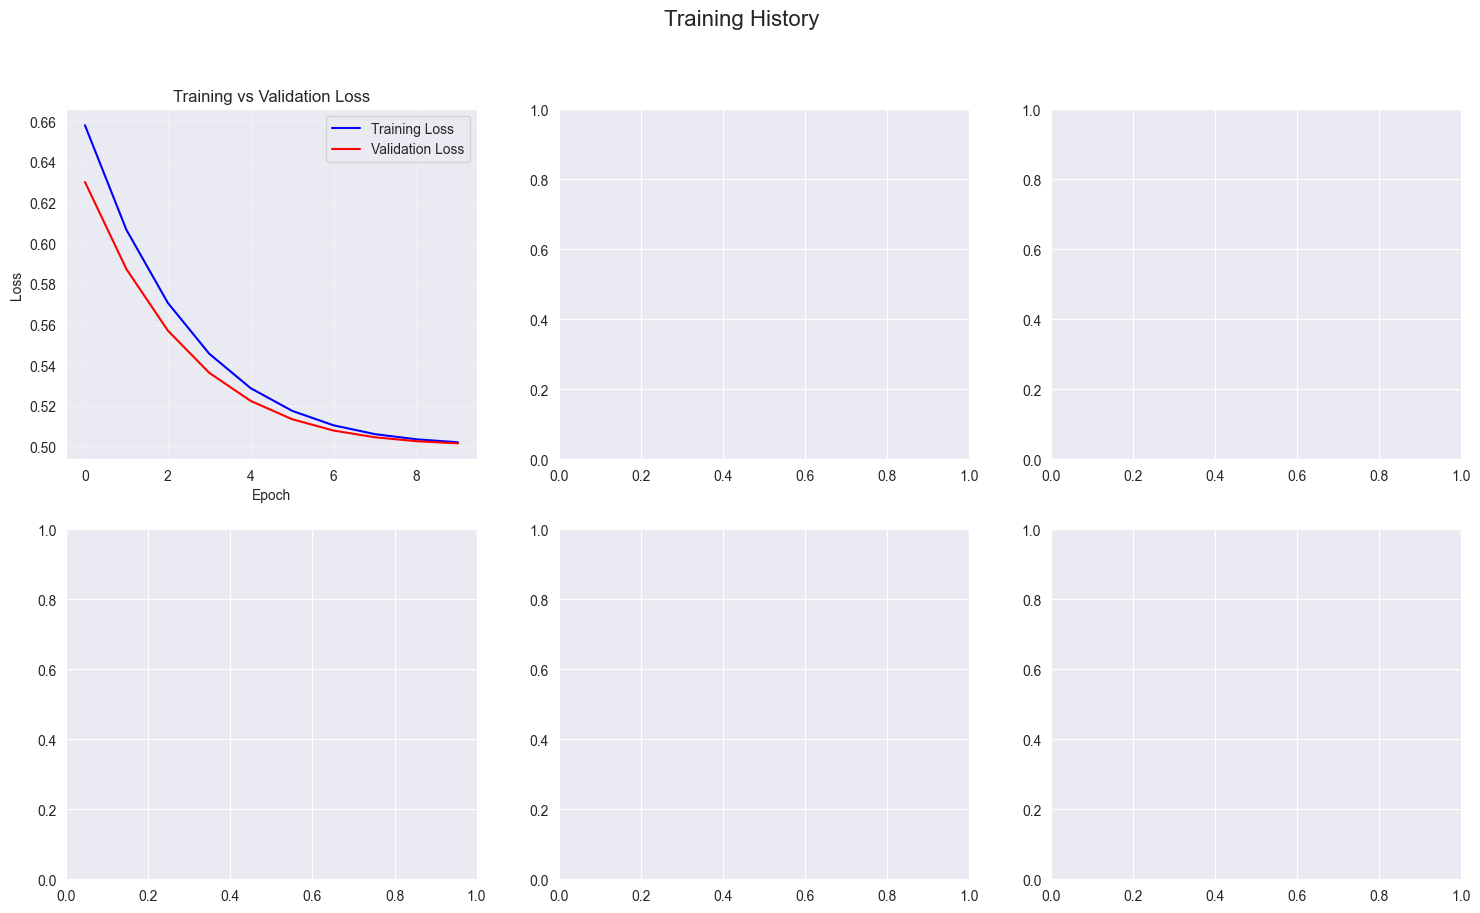

In [180]:
plot_training_history(train_losses, val_losses, val_metrics, save_path='training_history.png')